# ***Clovis LECHIEN - EPITA 23/01/2025***

# **TP : Explicabilité des modèles de deep learning pour les images avec LIME et SHAP**

## **Objectif**
Ce TP vise à explorer comment interpréter les prédictions d’un modèle de deep learning appliqué aux images à l’aide de **LIME** et **SHAP**. Ces outils permettent d’identifier les parties de l’image qui influencent le plus les décisions du modèle, contribuant ainsi à rendre les modèles plus transparents et compréhensibles.

---

## **Contexte**
Les modèles de deep learning, bien qu’efficaces, sont souvent considérés comme des boîtes noires. Comprendre pourquoi un modèle fait une certaine prédiction est essentiel pour :  
1. Identifier les biais potentiels dans le modèle.  
2. Valider la fiabilité des prédictions dans des applications sensibles.  
3. Construire la confiance des utilisateurs finaux.

Dans ce TP, nous allons :  
1. Charger un modèle de classification d’images pré-entraîné avec PyTorch.  
2. Utiliser ce modèle pour prédire les classes d’images fournies.  
3. Appliquer **LIME** et **SHAP** pour expliquer ces prédictions.  
4. Comparer les visualisations générées par ces deux outils et analyser les résultats.

---

## **Plan du TP**

### **Étape 1 : Préparation de l’environnement**
1. Installer les bibliothèques nécessaires pour PyTorch, LIME, et SHAP.  
2. Télécharger ou préparer un ensemble d’images pour les tests (votre dataset préféré, des images issues d’ImageNet, etc.).

---

### **Étape 2 : Charger un modèle pré-entraîné**
1. Nous allons utiliser un modèle pré-entraîné disponible dans PyTorch, comme ResNet18 ou VGG16, avec des poids pré-entraînés sur ImageNet.  
2. Le modèle sera utilisé pour effectuer des prédictions sur les images, après les avoir redimensionnées et normalisées en fonction des besoins du modèle.  
3. Pour chaque image, nous afficherons les classes prédites avec leurs scores de confiance.

---

### **Étape 3 : Explicabilité avec LIME**
1. **Présentation de LIME :**  
   LIME fonctionne en créant des perturbations localisées sur une image (par exemple, en masquant des zones spécifiques) pour mesurer l’impact de chaque zone sur la prédiction.  
2. **Étapes :**  
   - Segmenter l’image en pixels ou en superpixels.  
   - Identifier les zones les plus influentes pour une prédiction donnée.  
   - Générer une heatmap mettant en évidence les zones importantes pour la classe prédite.  
3. Nous analyserons les résultats pour comprendre quelles parties de l’image influencent le plus la prédiction.

---

### **Étape 4 : Explicabilité avec SHAP**
1. **Présentation de SHAP :**  
   SHAP utilise la théorie des jeux pour attribuer une importance à chaque pixel ou groupe de pixels, en mesurant leur contribution à la prédiction.  
2. **Étapes :**  
   - Fournir les images prétraitées au modèle pour calculer les valeurs SHAP.  
   - Générer une visualisation qui montre les contributions positives et négatives des pixels ou des superpixels pour la prédiction.  
3. Nous interpréterons les visualisations en observant les zones qui favorisent ou défavorisent la classe prédite.

---

### **Étape 5 : Comparaison et analyse des résultats**
1. **Comparaison des visualisations :**  
   - Identifier les différences et similitudes entre les résultats de LIME et SHAP.  
   - Analyser les zones mises en évidence par chaque méthode.  
2. **Discussion :**  
   - Quels sont les points forts et limites de chaque méthode ?  
   - Les deux approches donnent-elles des explications cohérentes ?  
   - Quels défis rencontrons-nous en utilisant ces outils avec des modèles de grande taille ou des images complexes ?

---

## **Livrables attendus**
1. Les heatmaps générées par LIME et SHAP pour au moins deux images.  
2. Une analyse comparative des résultats obtenus avec LIME et SHAP.  
---

# **Préparation de l'environnement**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16

import torch
import torch.nn as nn
import torch.optim as optim

import shap

from lime.lime_image import LimeImageExplainer
from lime import lime_image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

Le dataset sur lequel j'ai choisi d'entraîner le modèle est **CIFAR10**.

Un dataset de 60000 images 32x32, réparties en deux sous jeux :
1. train set : 50000 images
2. test set : 10000 images

Il possède les 10 classes suivantes :

1. 'plane'
2. 'car'
3. 'bird'
4. 'cat'
5. 'deer'
6. 'dog'
7. 'frog'
8. 'horse'
9. 'ship'
10. 'truck'

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# **Chargement modèle pré-entraîné**

J'ai choisi de travailler avec le Convolutionnal Neural Netwrok suivant : **VGG16**.

Il a été pré-entraîné sur ImageNet, nous aurons donc besoin de le fine-tuner sur CIFAR10 avant de pouvoir faire des prédictions correctes.

In [7]:
model = vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, len(classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)

## *fine-tuning sur CIFAR10*

On gèle les paramètres du modèle et on ne laisse que la dernière couche dense à entraîner.

On va passer 2 fois sur le dataset, cela devrait amplement suffir à obtenir des résultats décents.

In [8]:
num_epochs = 2
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 500 == 499:  # Print loss every 500 batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0

print('Training done.')

[Epoch 1, Batch 500] loss: 0.721
[Epoch 1, Batch 1000] loss: 0.514
[Epoch 1, Batch 1500] loss: 0.476
[Epoch 2, Batch 500] loss: 0.390
[Epoch 2, Batch 1000] loss: 0.362
[Epoch 2, Batch 1500] loss: 0.348
Training done.


In [50]:
model.eval()
correct_top1 = 0
correct_top5 = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        correct_top1 += (predicted == labels).sum().item()

        _, top5_preds = torch.topk(outputs, 5, dim=1)
        correct_top5 += sum([labels[i].item() in top5_preds[i] for i in range(labels.size(0))])

        total += labels.size(0)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print(f'TOP-1 Accuracy on the test set: {100 * correct_top1 / total:.2f}%')
print(f'TOP-5 Accuracy on the test set: {100 * correct_top5 / total:.2f}%')

TOP-1 Accuracy on the test set: 87.13%
TOP-5 Accuracy on the test set: 99.65%


Après fine-tuning sur 2 epochs, nous arrivons à de très bonnes performances :

1. TOP-1 Accuracy : **87.13%**
2. TOP-5 Accuracy : **99.65%**

La matrice de confusion suivante nous permet de mieux visualiser les classes qui sont problématiques.

En l'occurence on remarque que le modèle a quelques difficultés à comprendre que *les chiens ne font pas des chats*..

On va donc par la suite s'intéresser à ces deux classes en particulier pour l'explicabilité.

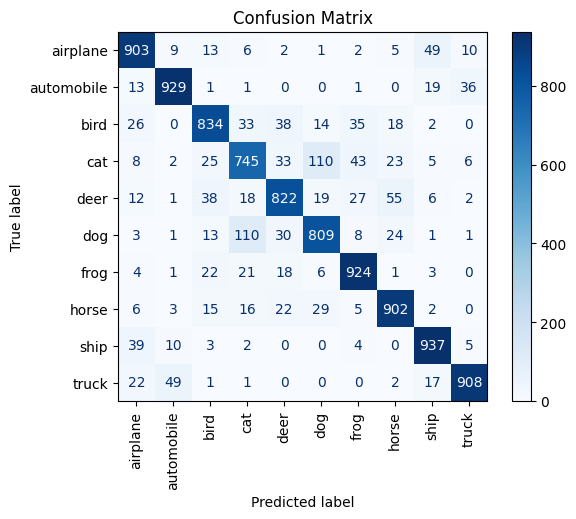

In [10]:
conf_matrix = confusion_matrix(all_labels, all_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=trainset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

In [64]:
cat_label = 3  # Classe "chat" dans CIFAR-10
dog_label = 5  # Classe "chien" dans CIFAR-10

In [65]:
cat_image = None
dog_image = None

for images, labels in testloader:
    for i in range(labels.size(0)):
        if labels[i].item() == cat_label and cat_image is None:
            cat_image = images[i].to(device)
            cat_image_label = labels[i].item()
        elif labels[i].item() == dog_label and dog_image is None:
            dog_image = images[i].to(device)
            dog_image_label = labels[i].item()
        if cat_image is not None and dog_image is not None:
            break
    if cat_image is not None and dog_image is not None:
        break

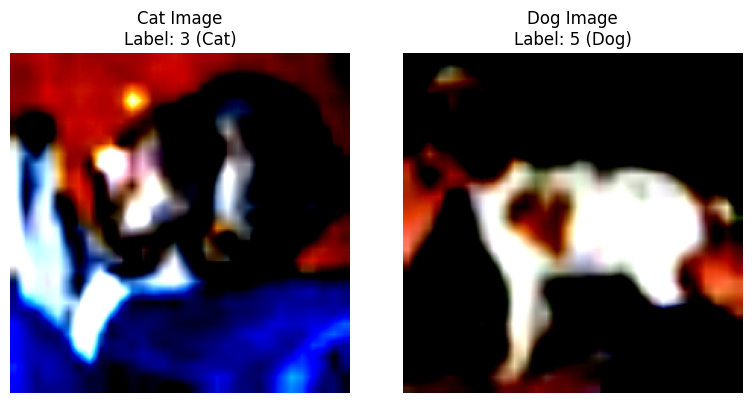

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(cat_image.cpu().numpy().transpose(1, 2, 0))
axes[0].set_title(f"Cat Image\nLabel: {cat_image_label} (Cat)")
axes[0].axis("off")

axes[1].imshow(dog_image.cpu().numpy().transpose(1, 2, 0))
axes[1].set_title(f"Dog Image\nLabel: {dog_image_label} (Dog)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# **Explicabilité avec LIME**

In [76]:
def predict_fn(images):
    images = torch.tensor(images.transpose(0, 3, 1, 2)).to(device, dtype=torch.float32)
    outputs = model(images)
    return outputs.detach().cpu().numpy()


explainer = LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

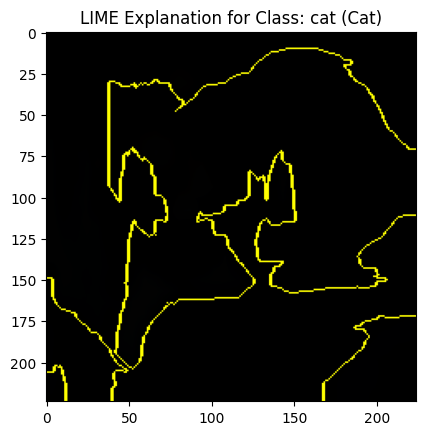

In [80]:
explanation = explainer.explain_instance(
    cat_image.cpu().numpy().transpose(1, 2, 0),
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f'LIME Explanation for Class: {classes[cat_image_label]} (Cat)')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

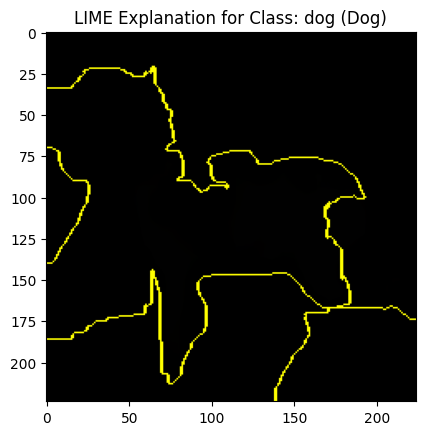

In [81]:
explanation = explainer.explain_instance(
    dog_image.cpu().numpy().transpose(1, 2, 0),
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f'LIME Explanation for Class: {classes[dog_image_label]} (Dog)')
plt.show()

C'est assez difficile à dire mais il semblerait que le modèle ait plus de mal à segmenter les images de chats que les images de chiens.

On arrive assez aisément à distinguer le crâne du chien, ainsi que son corps dans son intégralité. Je dirai même que c'est au niveau de la tête du chien que le modèle va faire son choix.

Pour le chat, c'est plutôt l'arrière train qui semble faire la différence, on reconnaît la silhouette dorsale du chat, la queue et les pâtes arrières.

On peut donc conclure avec cette méthode que lorsque le 'visage' d'un chat n'est pas visible en entièreté, le modèle fera son choix en regardant principalement l'arrière de l'animal. Pour le chien si le visage n'est pas visible de face, il fera son choix en regardant le crâne de l'animal.

L'exercice est assez dur, deux animaux quadripèdes avec de nombreuses similarités rendent l'analyse compliquée.

# **Explicabilité avec SHAP**

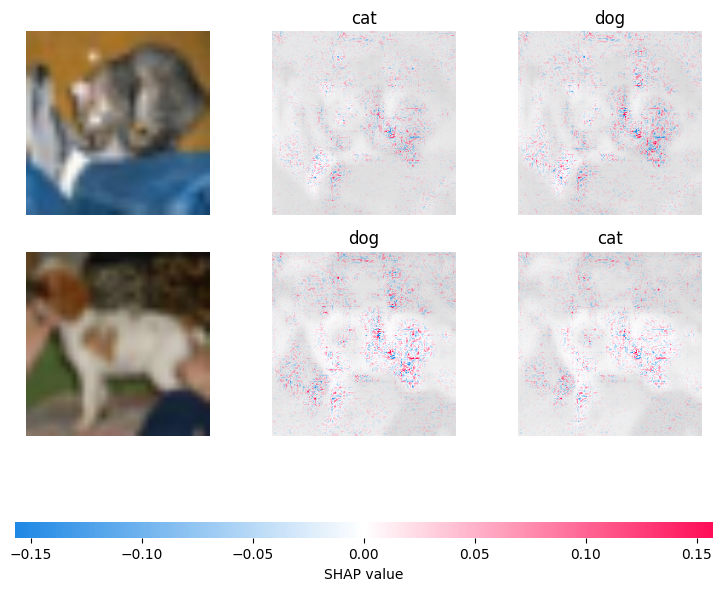

In [79]:
def normalize_for_shap(image):
    image = image.cpu().numpy().transpose(0, 2, 3, 1)
    image = (image * std) + mean
    image = np.clip(image, 0, 1)
    return image

to_explain = torch.stack([cat_image, dog_image])
to_explain_normalized = normalize_for_shap(to_explain)

background = torch.stack([cat_image, dog_image])
e = shap.GradientExplainer(model, background)

shap_values, indexes = e.shap_values(to_explain, ranked_outputs=2, nsamples=200)
index_names = np.vectorize(lambda x: classes[x])(indexes.cpu().numpy())

shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain_normalized, index_names)


Avec cette méthode on a légèrement plus de facilité sur ces deux classes très proches.

Il semblerait que pour le chat les hypothèses exprimées précedemment soit maintenues, l'arrière train fait à la fois office de zone décidant pour et contre l'attribution de la classe chat pour l'image. On constate un nombre assez important de point bleu au-dessus de la queue du chat, avec cependant une lignée de point rouge partant de la queue et remontant vers les pattes arrières. On discerne également une trace rouge le long du bord de la tête du chat.

Pour le chien malheureusement les prédictions faites avec la méthode LIME ne sont pas gardées avec SHAP, le crâne du chien ne dispose que de très peu d'attention positive ou négative de la part du modèle. On constate quelques points rouges au niveau des oreilles mais c'est tout dans cette zone. Là où l'on retrouve le plus d'activité encore une fois c'est au niveau du bassin du chien, et plus particulièrement les pattes arrières. Beaucoup de points bleus sur les flancs, beaucoup de points rouges sur les pattes arrières. On remarque aussi des points rouges sur les pattes avant.

Plus généralement, le modèle a du mal à discerner ces deux classes car les attentions sont partagées sur les mêmes zones entre ces deux animaux comme nous montre les 4 nuages de points, ceci rend la tâche complexe pour le modèle.

# **Comparaison et analyse des résultats**

Les différences observées entre ces deux méthodes reposent sur les zones d'attention du modèle, LINE a mis en valeur la segmentation quasi complète que le modèle a sur le corps de ces animaux et SHAP lui a montré principalement une zone d'attention sur le bas du corps.

On a par contre remarqué que le bas du corps pour chacune des méthodes avait été perçu comme importante.

Les points faibles sont assez évidents lorsque l'on compare des classes proches comme celles-ci, on a vite du mal à trouver des différences significatives.
On remarque aussi que pour LIME les découpages sont hasardeux et sensibles aux perturbations locales. J'ai ré itéré plusieurs fois cette méthode et j'ai trouvé qu'elle pouvait produire des explications peu stables pour des instances similaires.
Bien que SHAP soit plus précis que LIME, il peut être difficile d'interpréter la signification d'une valeur Shapley dans des modèles très complexes.

En général, LIME et SHAP visent à fournir des explications sur le comportement d'un modèle, mais elles utilisent des approches différentes. SHAP tend à fournir des explications plus cohérentes et justes par rapport à LIME, qui est plus approximatif dans sa méthode.
Les explications données par LIME peuvent parfois être incohérentes, notamment si les perturbations des données d'entrée ne sont pas suffisamment représentatives de l'ensemble des données. SHAP, en revanche, est plus fiable pour donner une vue d'ensemble sur les contributions des variables.

J'ai remarqué aussi que LIME était nettement plus rapide que SHAP.